In [53]:
import sys
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_roc_curve, mean_squared_error

from lightgbm import LGBMClassifier, plot_importance, plot_tree

from quant.Classification import Classification
from quant.factor import get_factors, get_label
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

np.set_printoptions(precision=4, suppress=True)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [17]:
klines_1h_file = 'data/futures_klines_1h_BTCUSDT_20200101_20220430.zip'
klind_df = pd.read_csv(klines_1h_file, index_col=0, parse_dates=True)
klind_df.shape

(20279, 9)

In [18]:
kline_factors = get_factors(klind_df, sign_ratio=1)
kline_factors.head()

,Price,Returns,CumReturns,Log_Returns,Returns_Ratio,O-C,H-L,PR5,PR10,PR20,PR30,PR60,MOM5,MOM10,MOM20,MOM30,MOM60,SMA5,SMA10,SMA20,SMA30,SMA60,EMA,Sign
datetime,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-03 13:00:00,7346.0700,0.0033,0.0243,0.0033,0.9873,-24.7600,68.1500,-0.0050,0.0041,0.0151,0.0068,-0.0020,88.0700,398.7200,379.2100,238.5100,135.8300,7332.1800,7273.3880,7112.6480,7113.7007,7156.3930,7171.4641,0
2020-01-03 14:00:00,7252.7000,-0.0127,0.0113,-0.0128,1.0087,93.0400,130.9500,-0.0247,-0.0497,-0.0131,-0.0185,-0.0166,-92.4500,48.3300,282.8500,104.1400,14.7100,7313.6900,7278.2210,7126.7905,7117.1720,7156.6382,7171.4721,1
2020-01-03 15:00:00,7316.0100,0.0087,0.0201,0.0087,1.0092,-63.2900,71.5600,0.0135,0.0072,0.0074,0.0072,0.0110,6.0100,100.4200,336.5700,156.6000,94.3600,7314.8920,7288.2630,7143.6190,7122.3920,7158.2108,7171.4864,1
2020-01-03 16:00:00,7383.0000,0.0092,0.0295,0.0091,0.9959,-67.6400,118.2200,0.0053,0.0117,0.0141,0.0094,0.0102,44.8900,186.0000,438.0500,225.1900,169.1400,7323.8700,7306.8630,7165.5215,7129.8983,7161.0298,7171.5072,0
2020-01-03 17:00:00,7352.9000,-0.0041,0.0253,-0.0041,0.9983,30.1000,67.1100,-0.0018,-0.0042,-0.0082,-0.0011,-0.0050,31.3300,154.8800,379.4000,216.6600,132.5900,7330.1360,7322.3510,7184.4915,7137.1203,7163.2397,7171.5251,0


In [19]:
kline_factors['Sign'].value_counts()

1    10345
0     9872
Name: Sign, dtype: int64

<AxesSubplot:title={'center':'BTCUSDT Futures (1m) Close Performance'}, xlabel='datetime'>

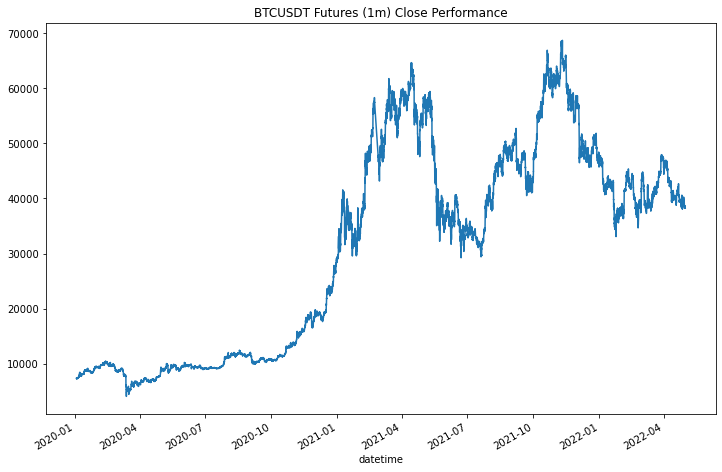

In [20]:
kline_factors['Price'].plot(figsize=(12, 8), title='BTCUSDT Futures (1m) Close Performance')

Text(0.5, 1.0, 'BTCUSDT Futures (1h) Factors Correlation')

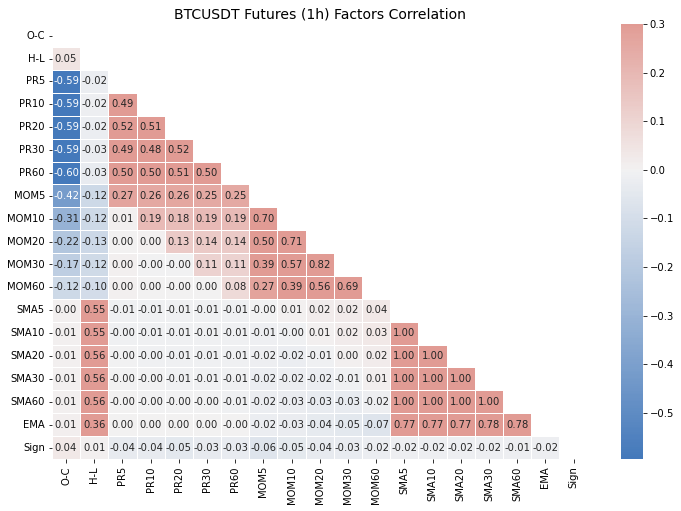

In [51]:
# Derive features correlation
corrmat = kline_factors.drop(['Price', 'Returns', 'CumReturns', 'Log_Returns', 'Returns_Ratio'], axis=1).corr()

# Visualize feature correlation
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrmat,
            annot=True,
            annot_kws={"size": 10},
            fmt="0.2f",
            mask=mask,
            cmap=cmap,
            vmax=.3,
            center=0,
            square=False,
            linewidths=.5,
            cbar_kws={"shrink": 1})

ax.set_title('BTCUSDT Futures (1h) Factors Correlation', fontsize=14, color='black')


In [22]:
X = kline_factors.drop(['Price', 'Returns', 'CumReturns', 'Log_Returns', 'Returns_Ratio', 'Sign'], axis=1)
y = kline_factors['Sign']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 10108, 10109


In [35]:
X_train_scaler = MinMaxScaler().fit_transform(X_train)
X_test_scaler = MinMaxScaler().fit_transform(X_test)
print(f"Train and Test Size {len(X_train_scaler)}, {len(X_test_scaler)}")

Train and Test Size 10108, 10109


pandas.core.indexes.base.Index

In [40]:
best_param = {'num_leaves': 10, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.25, 'colsample_bytree': 0.5}

gbm = LGBMClassifier(**best_param, verbosity=0, force_row_wise=True, random_state=64, device='gpu')
gbm.fit(X_train_scaler,
        y_train,
        eval_set=[(X_train_scaler, y_train), (X_test_scaler, y_test)],
        eval_metric='logloss',
        feature_name=X_train.columns.to_list())

[1]	training's binary_logloss: 0.689601	valid_1's binary_logloss: 0.698692
[2]	training's binary_logloss: 0.686912	valid_1's binary_logloss: 0.699456
[3]	training's binary_logloss: 0.685186	valid_1's binary_logloss: 0.699917
[4]	training's binary_logloss: 0.683313	valid_1's binary_logloss: 0.705918
[5]	training's binary_logloss: 0.680724	valid_1's binary_logloss: 0.707324
[6]	training's binary_logloss: 0.679047	valid_1's binary_logloss: 0.709744
[7]	training's binary_logloss: 0.677611	valid_1's binary_logloss: 0.711643
[8]	training's binary_logloss: 0.676068	valid_1's binary_logloss: 0.71286
[9]	training's binary_logloss: 0.674563	valid_1's binary_logloss: 0.713789
[10]	training's binary_logloss: 0.673187	valid_1's binary_logloss: 0.713084
[11]	training's binary_logloss: 0.672064	valid_1's binary_logloss: 0.714592
[12]	training's binary_logloss: 0.671077	valid_1's binary_logloss: 0.7207
[13]	training's binary_logloss: 0.669952	valid_1's binary_logloss: 0.739752
[14]	training's binary_l

LGBMClassifier(colsample_bytree=0.5, device='gpu', force_row_wise=True,
               learning_rate=0.25, max_depth=5, min_child_weight=3,
               num_leaves=10, random_state=64, verbosity=0)

Text(0.5, 1.0, 'Factors Importance')

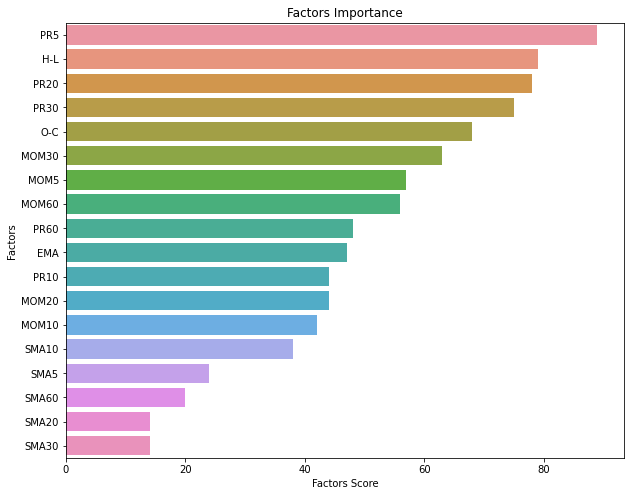

In [59]:
fig, ax = plt.subplots(figsize=(10, 8))
feature_imp = pd.DataFrame({
    'Factors Score': gbm.feature_importances_,
    'Factors': X.columns
}).sort_values(by='Factors Score', ascending=False)

sns.barplot(x=feature_imp['Factors Score'], y=feature_imp['Factors'])
ax.set_title('Factors Importance')

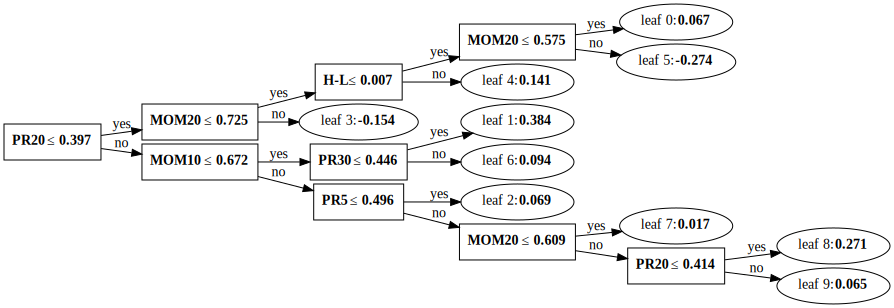

In [60]:
# plot_tree(gbm, figsize=(20, 12))

from lightgbm import create_tree_digraph
create_tree_digraph(gbm)

In [44]:
y_pred = gbm.predict(X_test_scaler)
y_pred

array([1, 1, 1, ..., 1, 1, 0])

In [45]:
acc_train = accuracy_score(y_train, gbm.predict(X_train_scaler))
acc_test = accuracy_score(y_test, y_pred)
acc_train, acc_test

(0.7195290858725761, 0.5077653576021367)

In [54]:
mse = mean_squared_error(y_test, y_pred, squared=True)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2train = gbm.score(X_train_scaler, y_train)
r2test = gbm.score(X_test_scaler, y_test)
mse, rmse, r2train, r2test

(0.4922346423978633,
 0.7015943574444304,
 0.7195290858725761,
 0.5077653576021367)

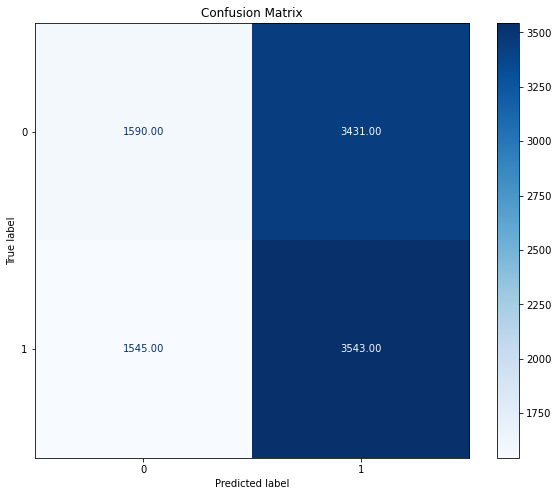

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(gbm, X_test_scaler, y_test, ax=ax, cmap='Blues', values_format='.2f')
plt.title('Confusion Matrix')
plt.grid(False)

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.32      0.39      5021
           1       0.51      0.70      0.59      5088

    accuracy                           0.51     10109
   macro avg       0.51      0.51      0.49     10109
weighted avg       0.51      0.51      0.49     10109



Text(0.5, 1.0, 'ROC Curve')

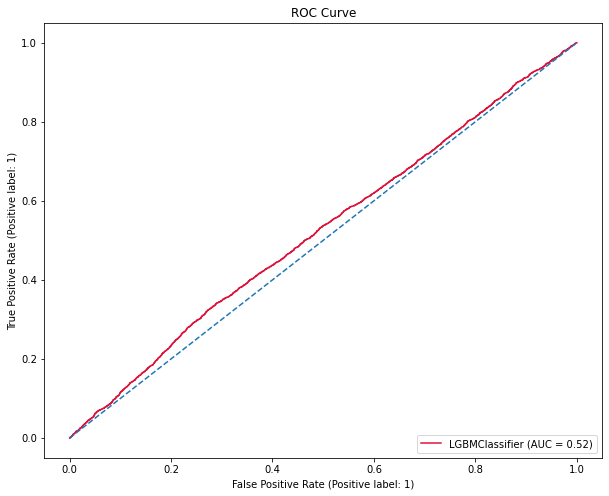

In [57]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_roc_curve(gbm, X_test_scaler, y_test, ax=ax, color='crimson')
ax.plot([0, 1], [0, 1], linestyle='--')
ax.set_title('ROC Curve')


### Trading Strategy


In [61]:
# Create a new dataframe to subsume outsample data
df = kline_factors[-len(y_test):]

# Predict the signal and store in predicted signal column
df['Signal'] = y_pred

# Calculate the strategy returns
df['Strategy'] = df['Log_Returns'] * df['Signal'].shift(1).fillna(0)

# Localize index for pyfolio
df.index = df.index.tz_localize('utc')

# Check the output
df[['Price', 'Log_Returns', 'Signal', 'Strategy']].tail(10)

,Price,Log_Returns,Signal,Strategy
datetime,,,,
2022-04-30 13:00:00+00:00,38490.4000,-0.0008,1,-0.0000
2022-04-30 14:00:00+00:00,38238.3000,-0.0066,1,-0.0066
2022-04-30 15:00:00+00:00,38439.9000,0.0053,1,0.0053
2022-04-30 16:00:00+00:00,38408.7000,-0.0008,1,-0.0008
2022-04-30 17:00:00+00:00,38271.3000,-0.0036,1,-0.0036
2022-04-30 18:00:00+00:00,38325.1000,0.0014,1,0.0014
2022-04-30 19:00:00+00:00,38447.7000,0.0032,1,0.0032
2022-04-30 20:00:00+00:00,38313.4000,-0.0035,1,-0.0035
2022-04-30 21:00:00+00:00,38284.4000,-0.0008,1,-0.0008


Start date,2021-03-04
End date,2022-04-30
Total months,481
,Backtest
Annual return,-2.295%
Cumulative returns,-60.604%
Annual volatility,10.711%
Sharpe ratio,-0.16
Calmar ratio,-0.04
Stability,0.67
Max drawdown,-64.212%


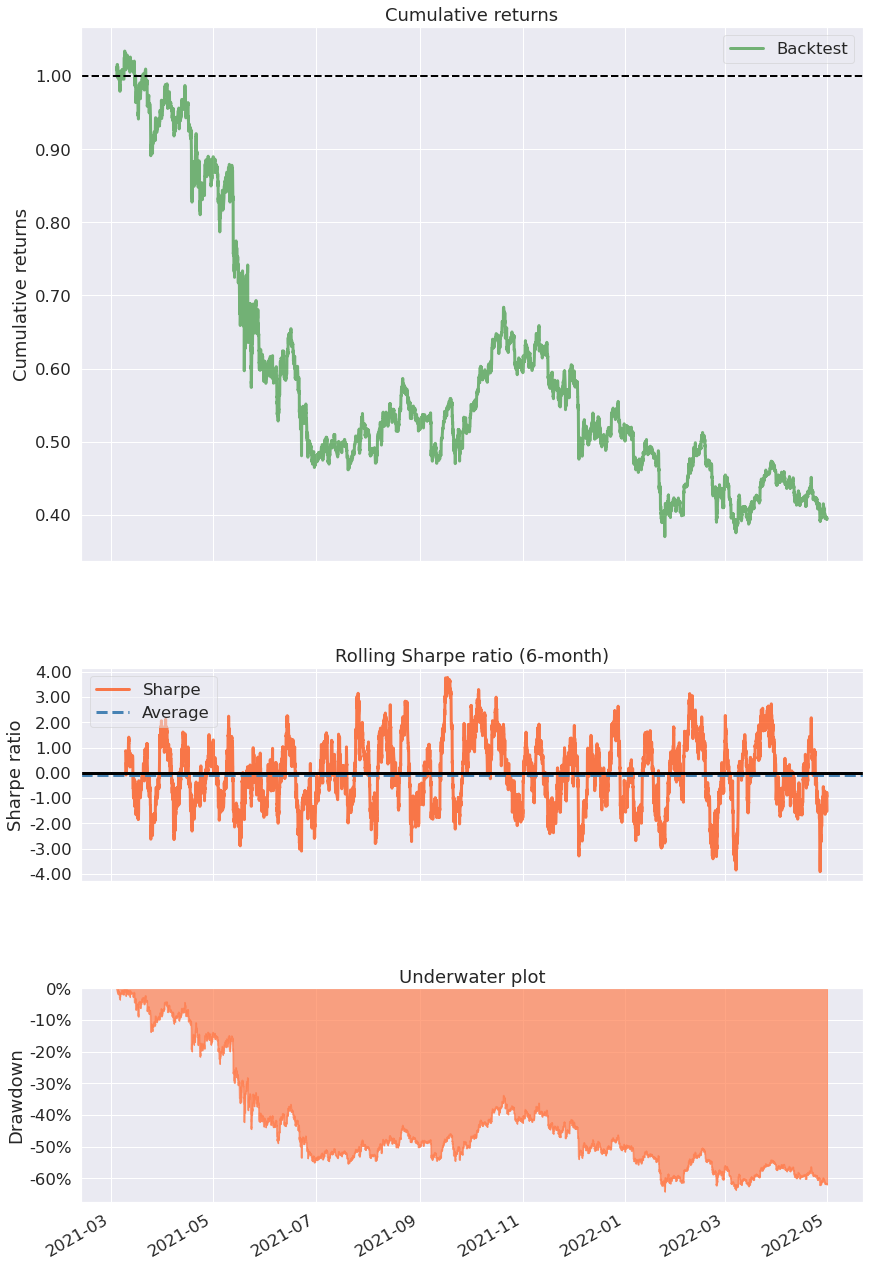

In [62]:
import pyfolio as pf

pf.create_simple_tear_sheet(df['Strategy'])

### Hyper-parameter Tuning

### RandomizedSearch

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html


In [11]:
param_grid = {
    'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'min_child_weight': [1, 3, 5, 7],
    'num_leaves': np.arange(10, 200, 20),
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
}

gbm = LGBMClassifier(verbosity=0, force_row_wise=True, random_state=64, device='gpu')
tscv = TimeSeriesSplit(n_splits=5, gap=1)
rs = RandomizedSearchCV(gbm, param_grid, n_iter=100, scoring='f1', cv=tscv, verbose=-1)
rs.fit(X_train_scaler, y_train, verbose=-1)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

RandomizedSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMClassifier(device='gpu', force_row_wise=True,
                                            random_state=64, verbosity=0),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'num_leaves': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190])},
                   scoring='f1', verbose=-1)

In [14]:
rs.best_params_

{'num_leaves': 10,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.25,
 'colsample_bytree': 0.5}

In [15]:
rs.best_score_

0.58224612212976